# Lesson 3: Object Detection

In [22]:
# Import necessary libraries
# Setup paths and import local libraries
import sys
from pathlib import Path
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import comet_ml for experiment tracking
import comet_ml

# To display the image
from PIL import Image
from PIL.ImageFilter import GaussianBlur

# Import necessary modules from transformers and ultralytics
from transformers import pipeline
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import torch
from ultralytics import SAM

# To access the current working directory
if "has_changed_dir" not in globals():
    # Change directory only the first time
    %cd ..
    # Set the flag to indicate the change has been made
    has_changed_dir = True
    %ls ..
# has_changed_dir = False

prj_path = Path('Prompt-Engineering-for-Vision-Models')
sys.path.insert(0, str(prj_path))

from utils import preprocess_outputs
from utils import show_boxes_and_labels_on_image
from utils import show_masks_on_image
from utils import make_bbox_annots
from utils import resize_image
from utils import get_model, plot_multy

In [23]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Import and prepare the models
#### SAM Model


In [6]:
# documentation: https://docs.ultralytics.com/models/sam-2/#how-to-use-sam-2-versatility-in-image-and-video-segmentation
versions = ['mobile_sam', 'sam_b', 'sam_l', 'sam2_b', 'sam2_t', 'sam2_s', 'sam2_l', 'sam2.1_b', 'sam2.1_t', 'sam2.1_s', 'sam2.1_l']
for SAM_version in versions:
    model = SAM(model=get_model(SAM_version))  # Specify the model path directly
    print(model.info())  # Display model information (optional)
model = SAM(model=get_model(versions[0]))
# Run inference (image or video)
#results = model("https://ultralytics.com/images/bus.jpg")  # image
# results = model("https://youtu.be/LNwODJXcvt4")  # video file

#results[0].show()  # Display results

Model summary: 246 layers, 10,130,092 parameters, 10,130,092 gradients
(246, 10130092, 10130092, 0.0)
Model summary: 173 layers, 93,735,472 parameters, 93,735,472 gradients
(173, 93735472, 93735472, 0.0)
Model summary: 257 layers, 312,342,832 parameters, 312,342,832 gradients
(257, 312342832, 312342832, 0.0)
Model summary: 403 layers, 80,833,666 parameters, 80,833,666 gradients
(403, 80833666, 80833666, 0.0)
Model summary: 307 layers, 38,945,986 parameters, 38,945,986 gradients
(307, 38945986, 38945986, 0.0)
Model summary: 339 layers, 46,043,842 parameters, 46,043,842 gradients
(339, 46043842, 46043842, 0.0)
Model summary: 595 layers, 224,430,130 parameters, 224,430,130 gradients
(595, 224430130, 224430130, 0.0)
Model summary: 403 layers, 80,850,178 parameters, 80,850,178 gradients
(403, 80850178, 80850178, 0.0)
Model summary: 307 layers, 38,962,498 parameters, 38,962,498 gradients
(307, 38962498, 38962498, 0.0)
Model summary: 339 layers, 46,060,354 parameters, 46,060,354 gradients
(33

#### Detector Model

In [24]:
# Info about ['google/owlvit-base-patch32'](https://huggingface.co/google/owlvit-base-patch32)

OWL_checkpoint = 'google/owlvit-base-patch32'
Dino_checkpoint = 'IDEA-Research/grounding-dino-base'
obj_det_model = Dino_checkpoint

detector = pipeline("zero-shot-object-detection", model=obj_det_model, device=device)


Device set to use cuda


### Load comet_ml logger

In [25]:
comet_ml.login(anonymous=True, project_name="3: Detector + SAM")
exp = comet_ml.Experiment()

COMET INFO: Comet is now logging experiments in anonymous mode, they will be publicly accessing by using the experiment url
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : medical_varnish_336
COMET INFO:     url                   : https://www.comet.com/uneven-pinniped-4835/3-detector-sam/a6e90e0d5af543908c97bb938cf1924c
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (10.13 MB)
COMET 

### Load the sample image

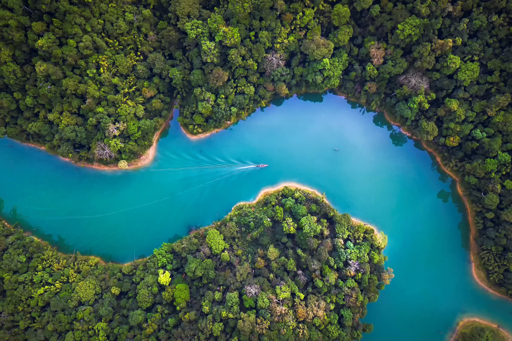

In [26]:
image_name = 'stream1'
raw_image = Image.open("images/" + image_name + ".jpg")
resized_image = resize_image(raw_image, input_size=512)
# Save the resized image
image_path_resized = "images/" + image_name + "_resized.jpg"
resized_image.save(image_path_resized)
resized_image

In [27]:
# What you want to identify in the image
text_prompt = "river"

output = detector(
    resized_image,
    candidate_labels = [text_prompt]
)
# Print the output to identify the bounding boxes detected
print(len(output))
print(output)

thr = 0.16
filtered_output = [entry for entry in output if entry['score'] > thr]
filtered_output

5
[{'score': 0.21513253450393677, 'label': 'river', 'box': {'xmin': 0, 'ymin': 0, 'xmax': 512, 'ymax': 340}}, {'score': 0.15769192576408386, 'label': 'river', 'box': {'xmin': 255, 'ymin': 163, 'xmax': 268, 'ymax': 167}}, {'score': 0.14574578404426575, 'label': 'river', 'box': {'xmin': 0, 'ymin': 86, 'xmax': 511, 'ymax': 340}}, {'score': 0.12226248532533646, 'label': 'river', 'box': {'xmin': 234, 'ymin': 163, 'xmax': 268, 'ymax': 169}}, {'score': 0.11224375665187836, 'label': 'river', 'box': {'xmin': 0, 'ymin': 0, 'xmax': 511, 'ymax': 171}}]


[{'score': 0.21513253450393677,
  'label': 'river',
  'box': {'xmin': 0, 'ymin': 0, 'xmax': 512, 'ymax': 340}}]

### Use the model

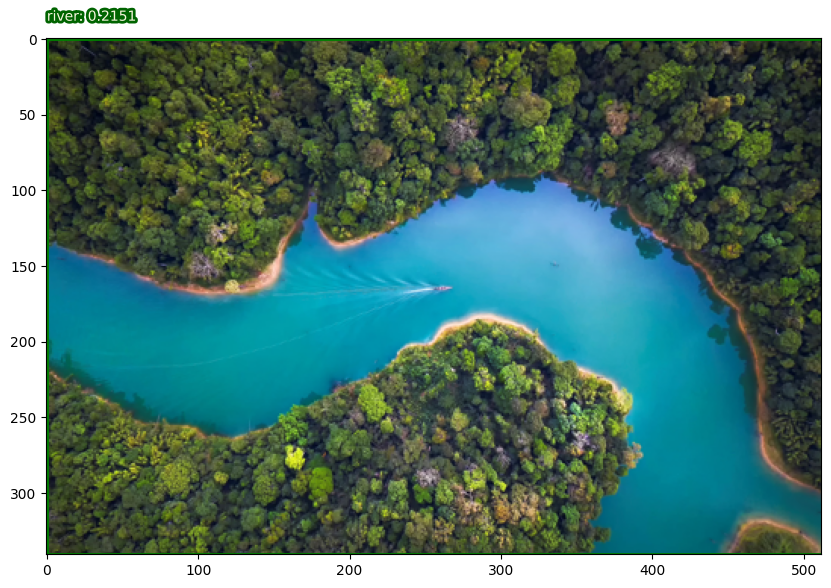

In [28]:
input_scores, input_labels, input_boxes = preprocess_outputs(filtered_output)
# Show the image with the bounding boxes
show_boxes_and_labels_on_image(
    resized_image,
    input_boxes[0],
    input_labels,
    input_scores
)

In [29]:

# Create a list of positive labels of same length as the number of predictions generated above
labels = np.repeat(1, len(filtered_output))
labels

array([1])

In [30]:
result = model.predict(
    resized_image,
    bboxes=input_boxes[0],
    labels=labels,
    device=device
)
result


0: 1024x1024 1 0, 144.6ms
Speed: 8.4ms preprocess, 144.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: '0'}
 obb: None
 orig_img: array([[[ 28,  22,  18],
         [ 36,  45,  39],
         [ 36,  59,  48],
         ...,
         [ 42,  41,  37],
         [ 42,  50,  43],
         [ 43,  63,  51]],
 
        [[ 21,   9,   6],
         [ 32,  35,  29],
         [ 34,  60,  48],
         ...,
         [ 37,  37,  33],
         [ 40,  49,  41],
         [ 39,  58,  46]],
 
        [[ 19,  11,   8],
         [ 27,  27,  21],
         [ 37,  63,  52],
         ...,
         [ 40,  43,  36],
         [ 34,  45,  38],
         [ 31,  48,  39]],
 
        ...,
 
        [[ 33,  56,  52],
         [ 31,  55,  50],
         [ 41,  65,  60],
         ...,
         [ 77, 105, 136],
         [ 98, 128, 161],
         [ 94, 126, 141]],
 
        [[ 37,  59,  55],
         [ 48,  69,  66],
         [ 36,  58,  54],
  

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: '0'}
 obb: None
 orig_img: array([[[ 28,  22,  18],
         [ 36,  45,  39],
         [ 36,  59,  48],
         ...,
         [ 42,  41,  37],
         [ 42,  50,  43],
         [ 43,  63,  51]],
 
        [[ 21,   9,   6],
         [ 32,  35,  29],
         [ 34,  60,  48],
         ...,
         [ 37,  37,  33],
         [ 40,  49,  41],
         [ 39,  58,  46]],
 
        [[ 19,  11,   8],
         [ 27,  27,  21],
         [ 37,  63,  52],
         ...,
         [ 40,  43,  36],
         [ 34,  45,  38],
         [ 31,  48,  39]],
 
        ...,
 
        [[ 33,  56,  52],
         [ 31,  55,  50],
         [ 41,  65,  60],
         ...,
         [ 77, 105, 136],
         [ 98, 128, 161],
         [ 94, 126, 141]],
 
        [[ 37,  59,  55],
         [ 48,  69,  66],
         [ 36,  58,  54],
  

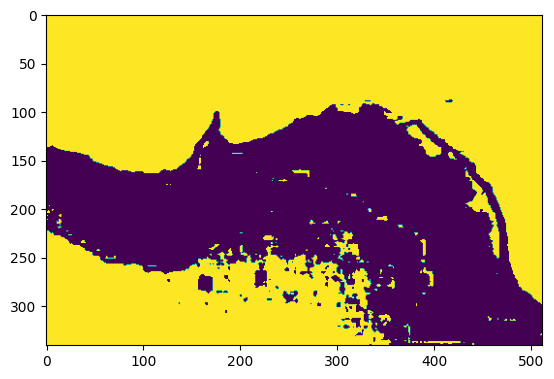

In [31]:
masks = result[0].masks.data.detach().cpu().numpy()

for mask in masks:
    plt.imshow(mask)

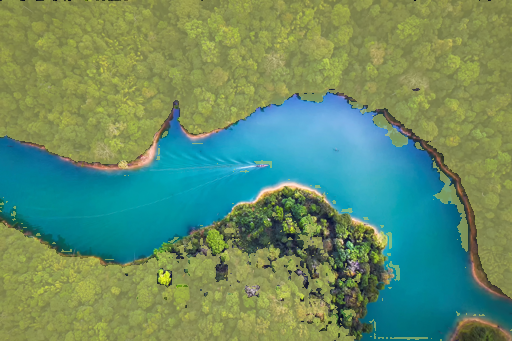

In [32]:
# Visualize the masks
show_masks_on_image(
    resized_image,
    masks
)

In [40]:
# --- All in one loop ---
# all_imgs = []
# all_titles = []

# speed_data = []  # store version and average speed

# for j, SAM_version in enumerate(versions):
#     print(f"Running SAM version: {SAM_version}")

#     model = SAM(model=get_model(SAM_version))
#     combined_speeds = []  # to store per-image total speed (ms) for this version

#     for i in range(1, 7):
#         image_name = 'stream' + str(i)
#         print(f"\tImage File: {image_name}")

#         raw_image = Image.open("images/" + image_name + ".jpg")
#         resized_image = resize_image(raw_image, input_size=512)

#         # Save resized image
#         image_path_resized = "images/" + image_name + "_resized.jpg"
#         resized_image.save(image_path_resized)

#         result = model.predict(
#             resized_image,
#             bboxes=input_boxes[0],
#             labels=labels
#         )

#         # Calculate total speed for this image
#         spd = result[0].speed
#         total_speed = spd['preprocess'] + spd['inference'] + spd['postprocess']
#         combined_speeds.append(total_speed)

#         # Process masks
#         masks = result[0].masks.data.detach().cpu().numpy()
#         for idx, mask in enumerate(masks):
#             if mask.ndim == 3 and mask.shape[0] == 1:  # remove channel dim
#                 mask = mask[0]
#             all_imgs.append(mask)
#             all_titles.append(f"{SAM_version} \n {image_name} \n mask {idx+1}")

#         print('-' * 100)

#     # Store average combined speed (ms) for this SAM version
#     avg_speed = np.mean(combined_speeds)
#     speed_data.append({"SAM_version": SAM_version, "avg_speed_ms": avg_speed})

#     print('-' * 100)

# # Create DataFrame of average speeds
# df_speed = pd.DataFrame(speed_data)
# df_speed.to_csv("sam_version_avg_speeds.csv", index=False)

# print("\nAverage Speeds per SAM Version (ms):")
# print(df_speed)


Running SAM version: mobile_sam
	Image File: stream1

0: 1024x1024 1 0, 30.8ms
Speed: 4.7ms preprocess, 30.8ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)
----------------------------------------------------------------------------------------------------
	Image File: stream2

0: 1024x1024 1 0, 27.3ms
Speed: 4.5ms preprocess, 27.3ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
----------------------------------------------------------------------------------------------------
	Image File: stream3

0: 1024x1024 1 0, 27.4ms
Speed: 5.9ms preprocess, 27.4ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
----------------------------------------------------------------------------------------------------
	Image File: stream4

0: 1024x1024 1 0, 27.5ms
Speed: 5.3ms preprocess, 27.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
---------------------------------------------------------------------------------

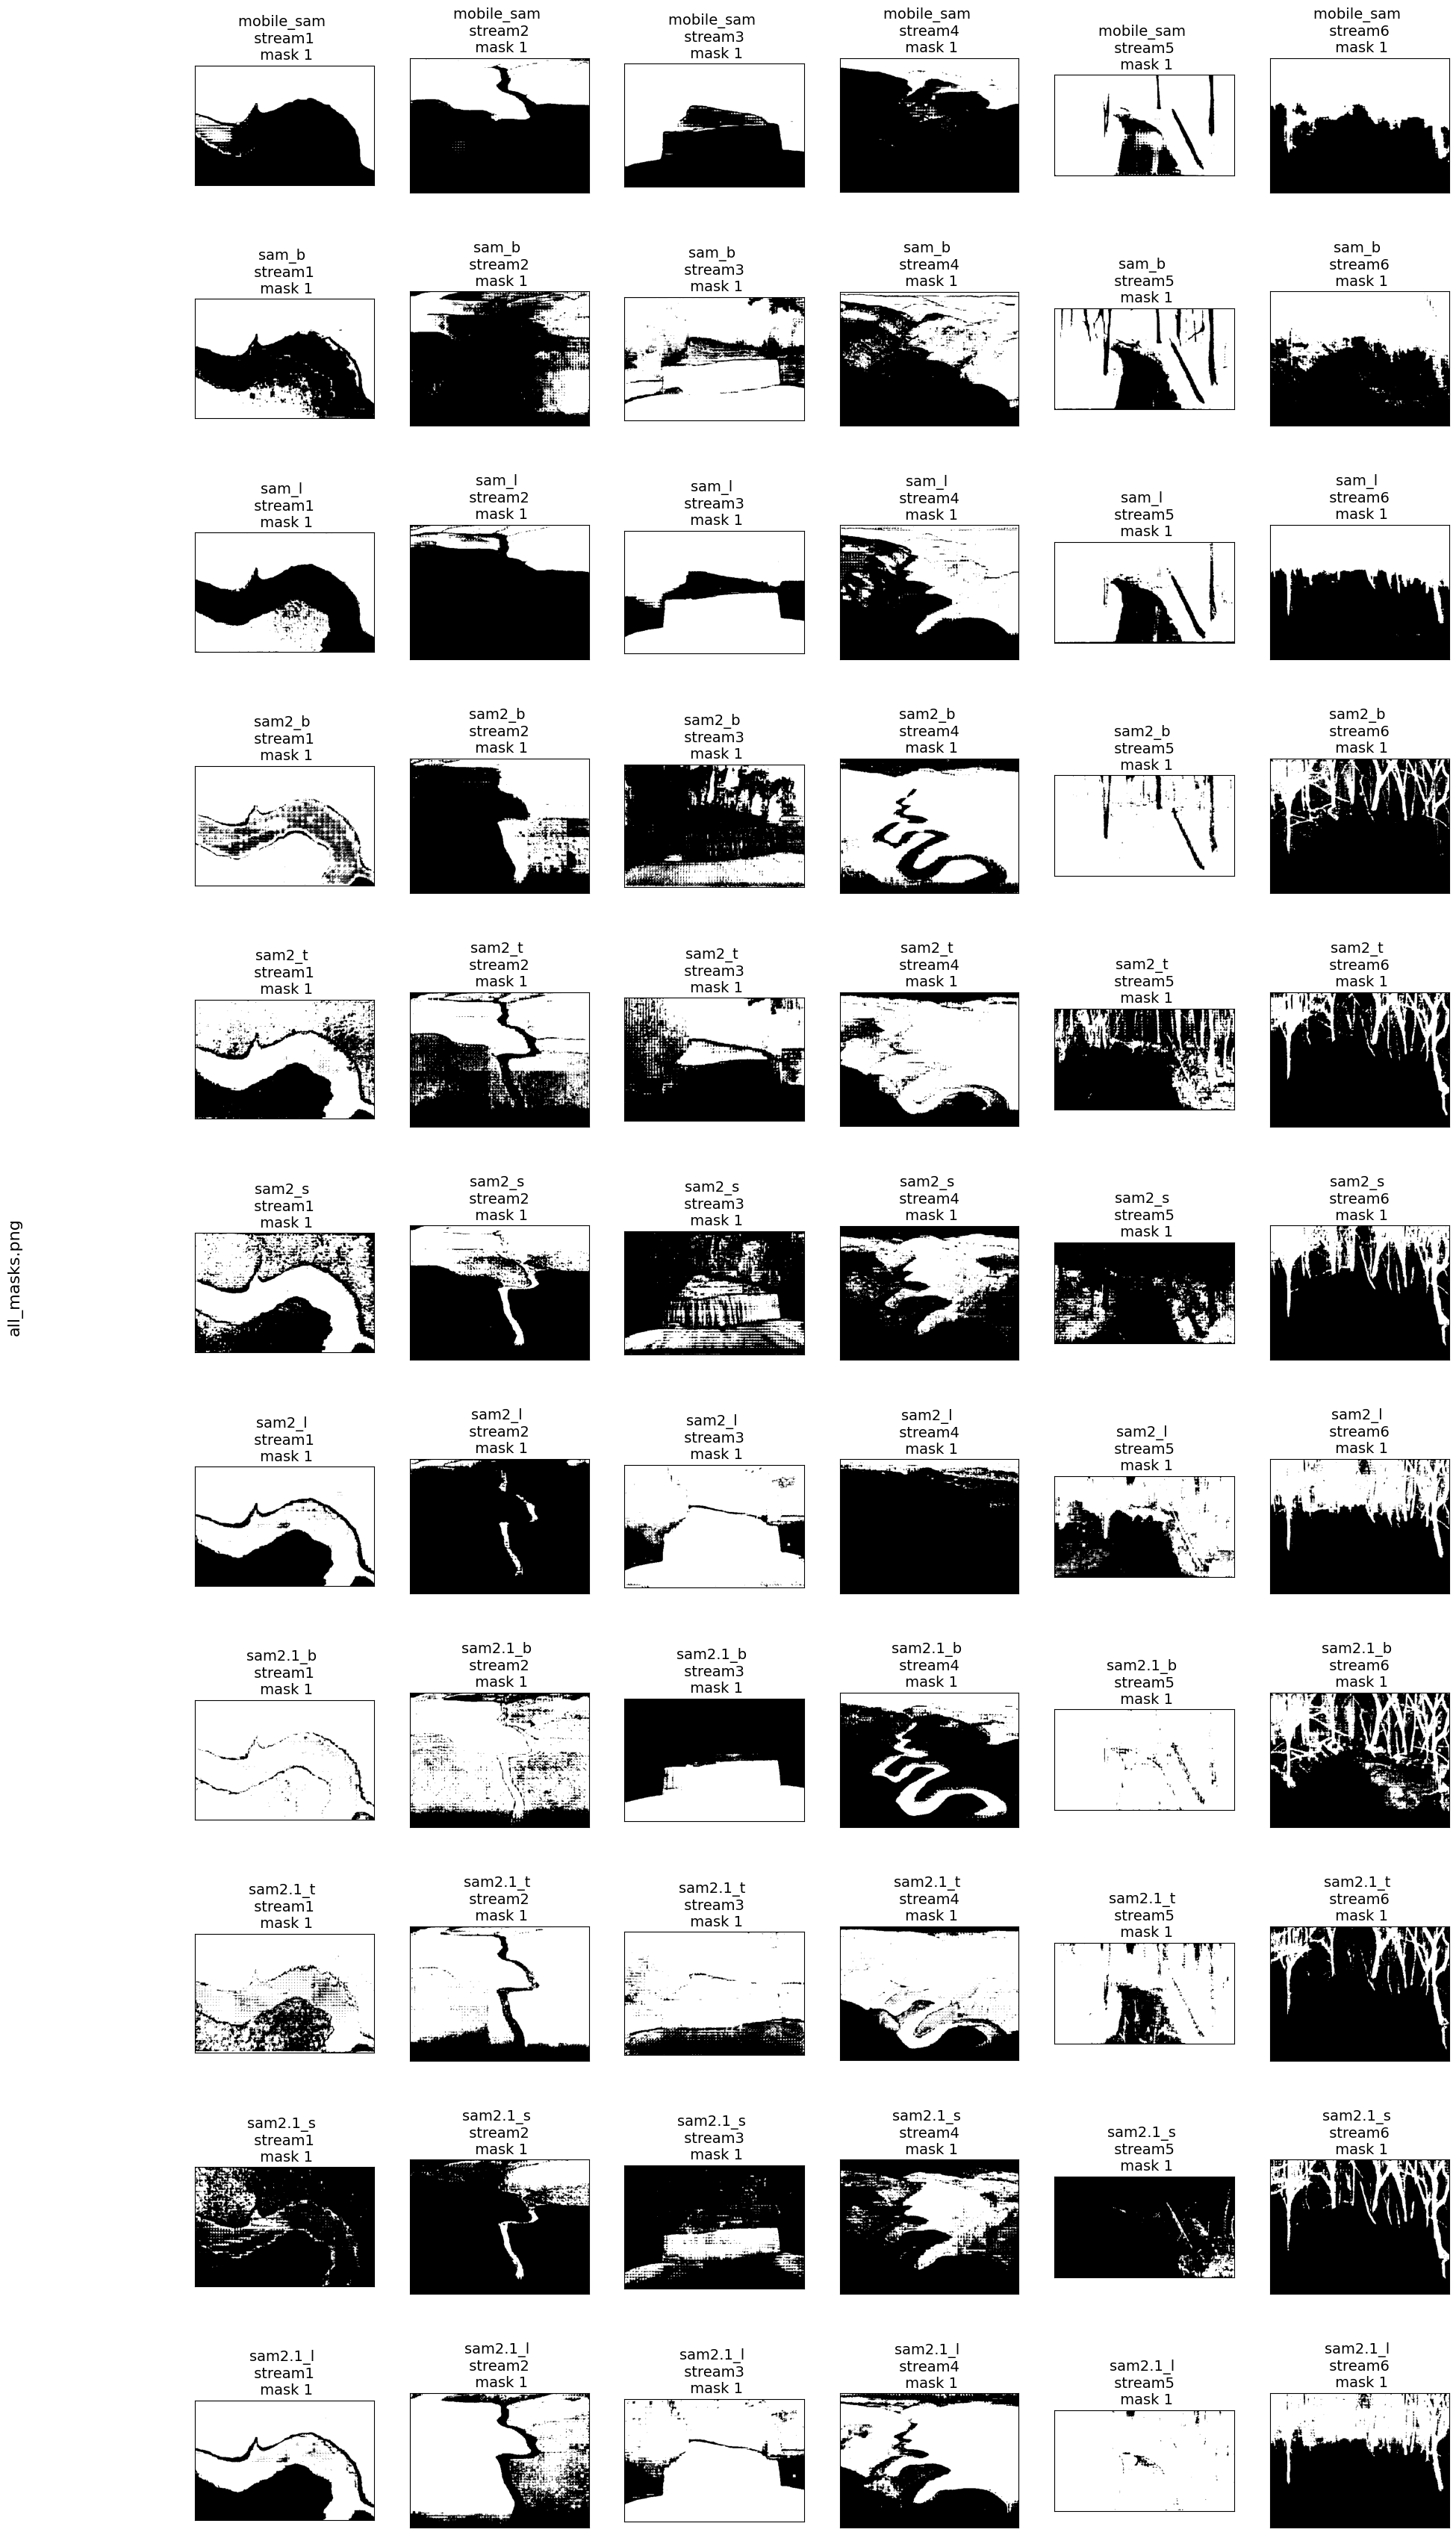

In [50]:
# # Plot all collected masks
# plot_multy(
#     imgs=all_imgs,
#     output_dir="all_masks.png",
#     cols=6,  # number of masks per version
#     rows=len(versions),
#     titles=all_titles
# )

## Blur Face

In [29]:
candidate_labels = ["human face"]
# Define a new Comet experiment for this new pipeline
exp = comet_ml.Experiment()
# Log image to the experiment
_ = exp.log_image(
    resized_image,
    name = "Raw image"
)

# Apply detector model to the image
output = detector(
    resized_image,
    candidate_labels=candidate_labels
)

input_scores, input_labels, input_boxes = preprocess_outputs(output)
input_boxes

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : dusty_drywall_1125
COMET INFO:     url                   : https://www.comet.com/uneven-pinniped-4835/3-detector-sam/a732e03e36f347bb94675e4905a16440
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (8.01 MB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code       

[[[0, 0, 512, 383],
  [237, 22, 348, 178],
  [243, 0, 512, 384],
  [0, 21, 344, 383],
  [0, 0, 367, 383]]]

In [ ]:
metadata = {
    "prompt": candidate_labels,
    "SAM version": SAM_version,
    "Obj Detector": obj_det_model
}
annotations = make_bbox_annots(
    input_scores,
    input_labels,
    input_boxes,
    metadata
)
_ = exp.log_image(
    raw_image,
    annotations= annotations,
    metadata=metadata,
    name= "OWL output"
)
result = model.predict(
    image_path_resized,
    bboxes=input_boxes[0],
    labels=np.repeat(1, len(input_boxes[0]))
)

In [ ]:
blurred_img = resized_image.filter(GaussianBlur(radius=100))
blurred_img

In [ ]:
masks = result[0].masks.data.cpu().numpy()
# Create an array of zeroes of the same shape as our image mask
total_mask = np.zeros(masks[0].shape)
# Add each output mask to the total_mask
for mask in masks:
    total_mask = np.add(total_mask,mask)

# Where there is any value other than zero (where any masks exist), show the blurred image
# Else, show the original (unblurred) image
output = np.where(
    np.expand_dims(total_mask != 0, axis=2),
    blurred_img,
    resized_image
)
plt.imshow(output)

In [ ]:
metadata = {
    "OWL prompt": candidate_labels,
    "SAM version": SAM_version,
    "OWL version": obj_det_model
}
_ = exp.log_image(
    output,
    name="Blurred masks",
    metadata = metadata,
    annotations=None
)
